<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 14

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
        ```
        git reset --hard origin/main
        ```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Tutorial on using Gaussian Processes
    - Gaussian Process Regression for noiseless and noisy datasets using [scikit-learn](https://scikit-learn.org)

**Reading material**: This notebook + (GPs in Section 17.2 of book)

**Optional reading material (GPs bible)**: Rasmussen, Carl E. *Gaussian Processes for Machine Learning*. MIT press, 2006. Available online [here](https://gaussianprocess.org/gpml/chapters/RW.pdf)

## Gaussian processes

Last Lecture we saw that Gaussian processes (GPs) are a kernel machine learning method.

Today we will see GPs in action!

* We will develop an intuition for the influence of the different hyperparameters in GPs

* You will discover that the hyperparameters of GPs are not just pre-assumed values that we impose in the prior! Instead, GP training includes hyperparameter optimization... Next lecture we will explain how GP packages optimize the hyperparameters.

Today, we are focusing on learning how to do Gaussian Process regression for one-dimensional datasets.

We will consider the function to be learned the same that we used in previous lectures $f(x) = x \sin(x)$

In [2]:
from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)

n_data = 50 # number of points in our dataset
testset_ratio = 0.90 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # create dataset with uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_data, test_size=testset_ratio,
                                    random_state=seed)

x_train = X_train.ravel() # just for plotting later
x_test = X_test.ravel() # just for plotting later

print("Here's a print of X_train:\n", X_train)

Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


## Gaussian processes with <font color='red'>homoscedastic noise</font>

Let's recap the PPD of Gaussian processes assuming **homoscedastic noise** we found in the last Lecture:



$$\require{color}
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid \mu^* +
{\mathbf{k}^*}^T (\mathbf{K}+\sigma^2\mathbf{I}_N)^{-1}\mathbf{y} \,,\, {\sigma^*}^2 + k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T (\mathbf{K}+\sigma^2\mathbf{I}_N)^{-1} \mathbf{k}^*\right)
$$

However, usually most ML pachages assume a zero mean function $\mu^*$ (they are assuming a prior on the "weights" with zero mean) and zero aleatoric variance for the predicted points $\sigma(\mathbf{x}^*)={\sigma^*}^2$ that is only equal to the constant $\sigma^2$ for all $N$ training points, i.e. $\sigma(\mathbf{x}_n) = \sigma^2$. So, the usual PPD for homoscedastic noise that most ML packages assume is:

$$
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid 
{\mathbf{k}^*}^T (\mathbf{K}+\sigma^2\mathbf{I}_N)^{-1}\mathbf{y} \,,\, k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T (\mathbf{K}+\sigma^2\mathbf{I}_N)^{-1} \mathbf{k}^*\right)
$$

* In the scikit-learn package, they call ${\color{red}\alpha}$ to $\sigma^2$, i.e. $\sigma^2 = \alpha$. In a non-Bayesian perspective (of models like Ridge regression), sometimes you see people calling $\alpha$ the Tikhonov regularization.

For completeness, remember that the PPD of GPs depends on the **kernel function**:

$$
k(\mathbf{x}^*, \mathbf{x}^*) \quad \text{where $k$ is a chosen kernel function}
$$

the **kernel vector**:

$$
{\mathbf{k}^*}^T = [k(\mathbf{x}_1, \mathbf{x}^*), k(\mathbf{x}_2, \mathbf{x}^*), \ldots, k(\mathbf{x}_N, \mathbf{x}^*) ] \quad \text{where $N$ is the number of training points}
$$


and the kernel matrix a.k.a. **Covariance matrix**:  

$$
\mathbf{K} = \begin{bmatrix} k(\mathbf{x}_1, \mathbf{x}_1) & k(\mathbf{x}_1, \mathbf{x}_2) & \cdots & k(\mathbf{x}_1, \mathbf{x}_N) \\
k(\mathbf{x}_2, \mathbf{x}_1) & k(\mathbf{x}_2, \mathbf{x}_2) & \cdots & k(\mathbf{x}_2, \mathbf{x}_N) \\
\vdots & \vdots & \ddots & \vdots \\
k(\mathbf{x}_N, \mathbf{x}_1) & k(\mathbf{x}_N, \mathbf{x}_2) & \cdots & k(\mathbf{x}_N, \mathbf{x}_N) \\
\end{bmatrix}
$$

By far the most common kernel used in GPs is a kernel that results from multiplying a Constant kernel (with hyperparameter $s^2$) by the RBF kernel (with hyperparameter $l$):

$$
k(x_i,x_j) = {\color{red}s}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}l}^2}\right)}
$$

In this case, the entire PPD only depends on **two hyperparameters** ($s^2$ and $l$) and it does not explicitly depend on any parameter! This is also why GPs are often called a **non-parametric** ML model, although they have hyperparameters!

I am showing the PPD for homoscedastic noise here again for you to confirm this:

$$
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid 
{\mathbf{k}^*}^T (\mathbf{K}+\sigma^2\mathbf{I}_N)^{-1}\mathbf{y} \,,\, k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T (\mathbf{K}+\sigma^2\mathbf{I}_N)^{-1} \mathbf{k}^*\right)
$$

## Tutorial on 1D regression with Gaussian Processes on <font color='red'>noiseless data</font>

### Gaussian Process Regression (GPR) for noiseless datasets

Let's make our first prediction using Gaussian processes for a noiseless dataset.

We will use a kernel that results from multiplying a Constant kernel (with hyperparameter $s^2$) by the RBF kernel (with hyperparameter $l$):

$$
k(x_i,x_j) = {\color{red}s}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}l}^2}\right)}
$$

with an initial guess for the hyperparameters as: $s = 1$ and $l = 10$.

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel

# Define points used for plotting
n_plot = 500 # number of points used for plotting the model
x_plot = np.linspace(0, 10, n_plot) # create dataset with uniformly spaced points
#x_plot = np.linspace(-10, 20, n_plot) # For in-class example
X_plot = np.reshape(x_plot,(-1,1)) # a 2D array that scikit-learn likes

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above (scikit-learn assumes constant s^2 if you just
                                     # write RBF and multiply by a scalar, or it uses the pure RBF kernel
                                     # (without s^2) if you do not multiply by a scalar.

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model.fit(X_train, y_train)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred, sigma_plot = gp_model.predict(X_plot, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred, sigma = gp_model.predict(X_test, return_std=True) # also output the uncertainty (std)

In [4]:
# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot, f(x_plot), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn

ax1.plot(x_plot, y_plot_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot, x_plot[::-1]]),
         np.concatenate([y_plot_pred - 1.9600 * sigma_plot,
                        (y_plot_pred + 1.9600 * sigma_plot)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train, y_train, 'ro', markersize=6, label="training points") # noiseless data
ax1.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$f(x)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
#ax1.set_ylim(-10, 15) # just to provide more space for the legend
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.close(fig1) # close the plot to see it in next cell

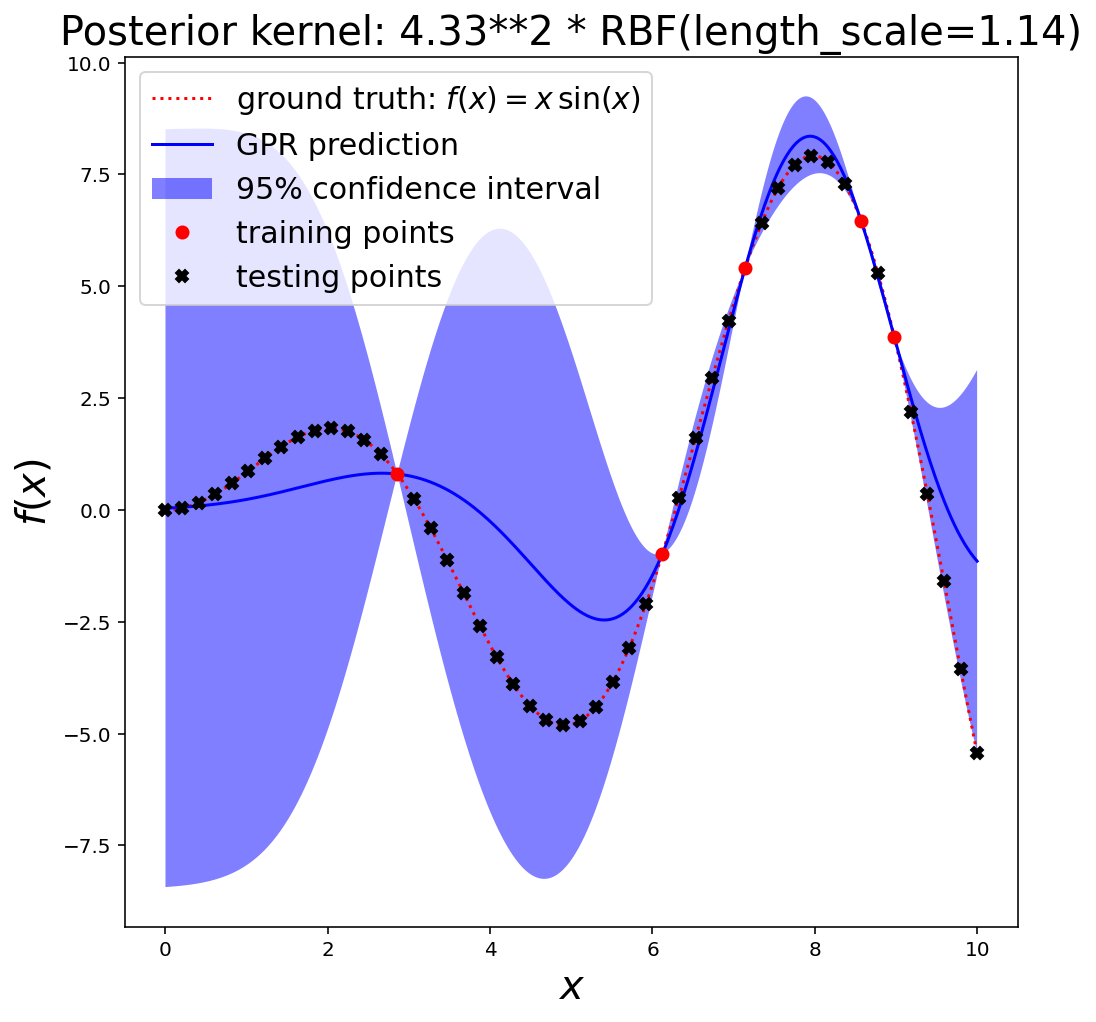

In [5]:
fig1 # plot figure.

## In-class example

Let's play with the previous cells to understand the GP approximation for the noiseless case by recreating the above plot considering different hyperparameters, different domain size etc.

1. Recreate the above plot considering the same kernel (ConstantKernel*RBF) but changing the domain bounds from $x \in (0, 10)$ to $x \in (-10, 20)$ so that you can see the model extrapolating.

2. Now see what happens when you consider non-negligible aleatoric uncertainty for the training data, i.e. considering that the noise at each training point is $\alpha = \sigma^2 = 2.5^2$.

* This should help you see that scikit-learn is only considering constant **aleatoric uncertainty** for the input points of $\sigma^2$ **that we are imposing** via $\alpha$ because in the extrapolation part of the domain (no training points) you only see the effect of the epistemic uncertainty $s^2$ (which is modeled by the constant kernel hyperparameter, as we will discuss more in a moment).

3. Revert back to the case with negligible aleatoric uncertainty at the input points, i.e. $\alpha = 1e-10$.

## In-class example (continued)

4. Turn off the hyperparameter optimizer (optimizer = None), and see the effect of particular choices of hyperparameter $l$ for the following kernel:

$$
k(x_i,x_j) = {\color{red}s}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}l}^2}\right)}
$$

which corresponds to a Constant kernel $s^2$ times the RBF kernel (with hyperparameter $l$).

4.1. For fixed hyperparameters $s^2=1.0$ and $l=10$.

4.2. For fixed hyperparameters $s^2=1.0$ and $l=1$.

4.3. For fixed hyperparameters $s^2=1.0$ and $l=0.1$.

* This should help you understand why $l$ is called the length scale hyperparameter (it is associated to the "roughness" of the response).

## In-class example (continued)

5. Still considering the hyperparameter optimizer turned off (optimizer = None), now investigate the effect of the constant kernel (hyperparameter $s^2$):

5.1. For fixed hyperparamaters $s^2=1.0$ and $l=1$.

5.2. For fixed hyperparamaters $s^2=2.5^2$ and $l=1$.

5.3. For fixed hyperparamaters $s^2=4^2$ and $l=1$.

* This should help you understand why $s^2$ is called the variance hyperparameter (it is the variance of the **epistemic uncertainty**, i.e. the prediction far away from the training data.
    * You can see this in plot 5.1 (where $s^2=1.0$) because the 95% confidence interval is $\pm 1.96\times 1.0 \approx \pm 2$, for 5.2 (where $s^2=2.5^2$) it is $\pm 1.96\times2.5 \approx \pm 5$ and for 5.3 (where $s^2=4.0^2$) it is $\pm 1.96\times4.0 \approx \pm 8$.)

## In-class example (continued)

6. Now "turn on" the hyperparameter optimization again (optimizer='fmin_l_bfgs_b') and train the model.

* You can see that the quality of interpolation is fantastic, but the extrapolation is quite bad... This behavior is typical of state-of-ther-art ML models.

* You should also observe that the Gaussian process reverts back to the zero mean function far away from the training points. That is the consequence of assuming a prior with zero mean.

## In-class example (continued)

7. Finally, consider different kernels and observe the quality of the approximation:

7.1. Use the Exponential-Sine-Squared kernel (uncomment the code in appropriate line).

7.2. Use the Matern kernel (uncomment the code in appropriate line).

* In this case, the $s^2 \times \text{RBF}$ kernel led to better results. Why?

### In-class Exercise 1

Fit a polynomial of degree 4 (Linear Least Squares with polynomial basis functions of degree 4) and compute the appropriate regression error metrics (R$^2$ and $\text{MSE}$) for that model as well as for the Gaussian process model using the RBF kernel.

In [6]:
# Write your code for Exercise 1:

# until here.

Gaussian Process Regression approximates the function much better...

* However, note that the **choice of kernel** used in GPR affects the quality of the prediction.

### Gaussian Process regression for <font color='red'>noisy datasets</font>

Let's recreate the noisy dataset from $f(x)=x\sin{x}$, as we did in Lecture 10:

We concluded that the PPD for a Gaussian process with **heteroscedastic noise** is:

$$\require{color}
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid \mu^* +
{\mathbf{k}^*}^T (\mathbf{K}+\mathbf{R})^{-1}\mathbf{y} \,,\, {\sigma^*}^2 + k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T (\mathbf{K}+\mathbf{R})^{-1} \mathbf{k}^*\right)
$$

where the noise $\sigma^* \equiv \sigma(\mathbf{x}^*)$ in points you want to predict is usually assumed to be zero, and where the aleatoric uncertainty at training points (noise matrix) is diagonal but where each entry is the noise level at data point $\mathbf{x}_i$ (sometimes this at least can be measured at every training point; althouh usually this is still not done):

$R_{ij} = \sigma_i^2\delta_{ij}$

where $\sigma_i \equiv \sigma(\mathbf{x}_i)$ is the noise assumed (or measured) at each training point $\mathbf{x}_i$, and $\delta_{ij}$ is the Kronecker delta (Identity matrix).

* In scikit-learn $\boldsymbol{\alpha}$ can also be a **vector**, i.e. $\alpha_i = \sigma_i^2$. This is one way of modeling heteroscedasticity (if you know the variance for your aleatoric uncertainty at each training point)

In [7]:
# Now let's also create the noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape) # np.random.random returns random number between [0.0, 1.0)
noise = np.random.normal(0, random_std) # sample vector from Gaussians with random standard deviation
y_noisy_data = y_data + noise # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?
# NOTE: since we are using the same seed and we do train_test_split on the same X_data and since y_noisy_data
#       is just y_data + noise, we are splitting the dataset exactly in the same way! This is nice because we
#       want to keep the comparison as fair as possible.

# Finally, for plotting purposes, let's convert the 2D arrays into 1D arrays (vectors):
x_train = X_train.ravel()
x_test = X_test.ravel()
y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

print("Note that X_train and X_test are the same data that we used for the noiseless case.")
print("Also note that noise in training data is:\n", noise_train)

Note that X_train and X_test are the same data that we used for the noiseless case.
Also note that noise in training data is:
 [ 1.41231288  0.98686933  2.76434295 -0.46226871  0.98526605]


Now let's train a GP but considering that we know the heteroscedastic noise at every training data point

* Knowing the noise at each training point is not common in practice. However, if you can do multiple measurements at each data point $x_i$ to determine the standard deviation of $y_i$ at that data point, then you can estimate the noise and include it in the "alpha" parameter of scikit-learn.

In [8]:
# Instanciate a Gaussian Process model with an RBF kernel + White kernel to learn the noise (not given)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Fitting for noisy data, if we have access to the uncertainty at the training points (usually we don't!), then
# we can include the noise level at the alpha parameter
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_train**2,
                                    optimizer='fmin_l_bfgs_b', n_restarts_optimizer=5)

# Fit to data to determine the parameters of the model
gp_model.fit(X_train, y_noisy_train)

# Make the predictions
y_noisy_pred, sigma_noisy = gp_model.predict(X_test, return_std=True) # predictions including uncertainty (std)
y_noisy_plot_pred, sigma_noisy_plot = gp_model.predict(X_plot, return_std=True) # for plotting

# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_plot, f(x_plot), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn
ax1.errorbar(x_train, y_noisy_train, np.abs(noise_train), fmt='ro', markersize=6, label=u'training points inc. uncertainty')
ax1.errorbar(x_test, y_noisy_test, np.abs(noise_test), fmt='kX', markersize=6, label=u'testing points inc. uncertainty')

ax1.plot(x_plot, y_noisy_plot_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot, x_plot[::-1]]),
         np.concatenate([y_noisy_plot_pred - 1.9600 * sigma_noisy_plot,
                        (y_noisy_plot_pred + 1.9600 * sigma_noisy_plot)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$f(x)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.set_ylim(-10, 15) # just to provide more space for the legend
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.close(fig1)

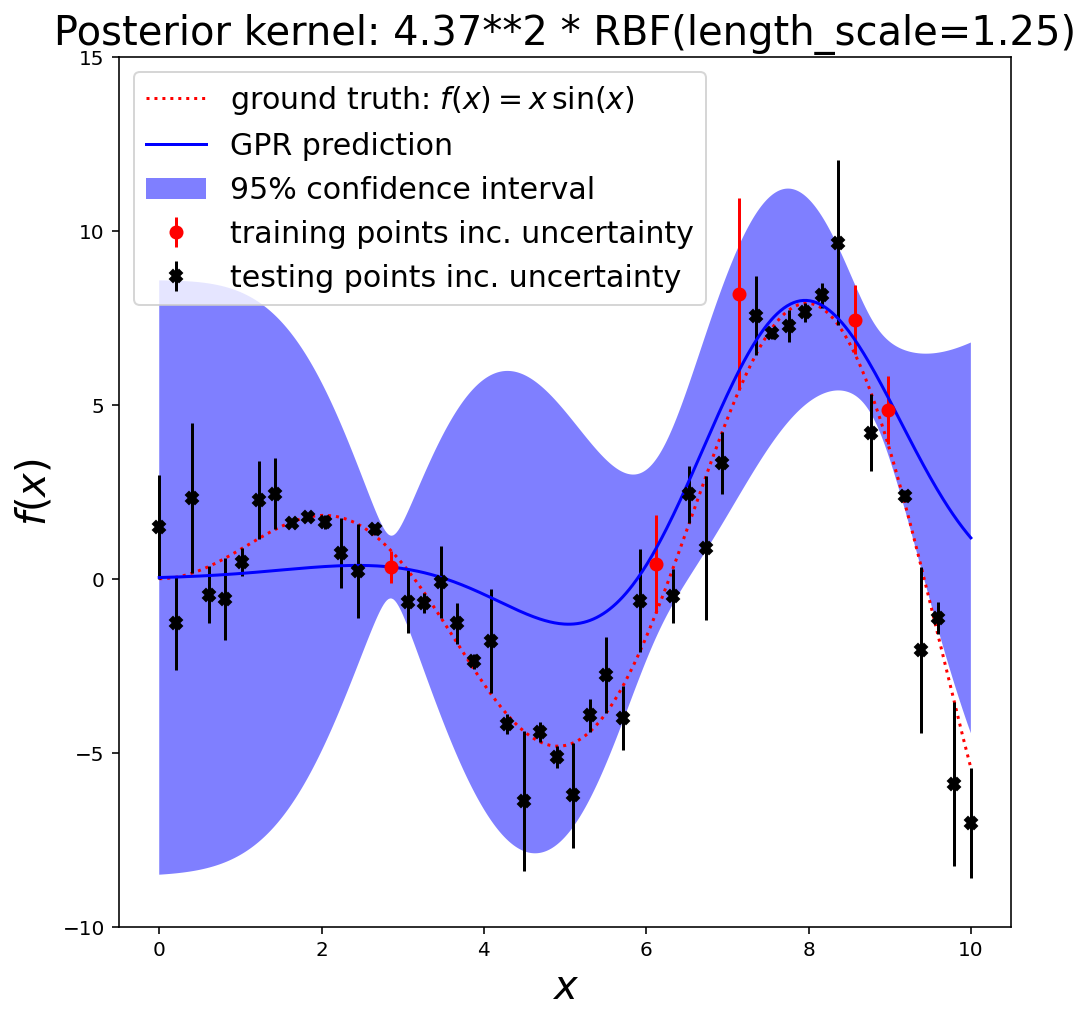

In [9]:
fig1 # plot figure.

### Exercise 2

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [10]:
# Exercise 2.

# until here.

Finally, let me show you something super cool!

There is a more general way to estimate aleatoric uncertainty when you **do not know the variance of your training points**.

This is possible by adding a white Kernel to the previous kernel:

$$
k(x_i,x_j) = {\color{red}s_1}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}l}^2}\right)} + {\color{red}s_2}^2\delta_{ij}
$$

In this case, however, you should not use the $\alpha$ parameter (assume it zero or close to zero).

The PPD for the heroscedastic Gaussian process where you want to **find the noise in your training points by setting it as a hyperparameter** instead of imposing the noise is then:

$$\require{color}
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid
{\mathbf{k}^*}^T \mathbf{K}^{-1}\mathbf{y} \,,\, k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T \mathbf{K}^{-1} \mathbf{k}^*\right)
$$

where you add a White kernel to the kernel function, for example use this kernel:

$$
k(x_i,x_j) = {\color{red}s_1}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}l}^2}\right)} + {\color{red}s_2}^2\delta_{ij}
$$

* However, be careful! The hyperparameter optimization when you include the White kernel can be difficult if there is not enough training data and if you use unreasonable bounds for the hyperparameter of the white kernel... You can play with the cell below and understand what I mean...

In [11]:
# Instanciate a Gaussian Process model with an RBF kernel + White kernel to learn the noise (not given)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(
    length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1) )

# Create the GP model but make sure that alpha=0.0 because now you have a White Kernel!
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                                    optimizer='fmin_l_bfgs_b', n_restarts_optimizer=5)

# Fit to data to determine the parameters of the model
gp_model.fit(X_train, y_noisy_train)

# Make the predictions
y_noisy_pred, sigma_noisy = gp_model.predict(X_test, return_std=True) # predictions including uncertainty (std)
y_noisy_plot_pred, sigma_noisy_plot = gp_model.predict(X_plot, return_std=True) # for plotting

# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_plot, f(x_plot), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn
ax1.errorbar(x_train, y_noisy_train, np.abs(noise_train), fmt='ro', markersize=6, label=u'training points inc. uncertainty')
ax1.errorbar(x_test, y_noisy_test, np.abs(noise_test), fmt='kX', markersize=6, label=u'testing points inc. uncertainty')

ax1.plot(x_plot, y_noisy_plot_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot, x_plot[::-1]]),
         np.concatenate([y_noisy_plot_pred - 1.9600 * sigma_noisy_plot,
                        (y_noisy_plot_pred + 1.9600 * sigma_noisy_plot)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$f(x)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.set_ylim(-10, 15) # just to provide more space for the legend
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.close(fig1)

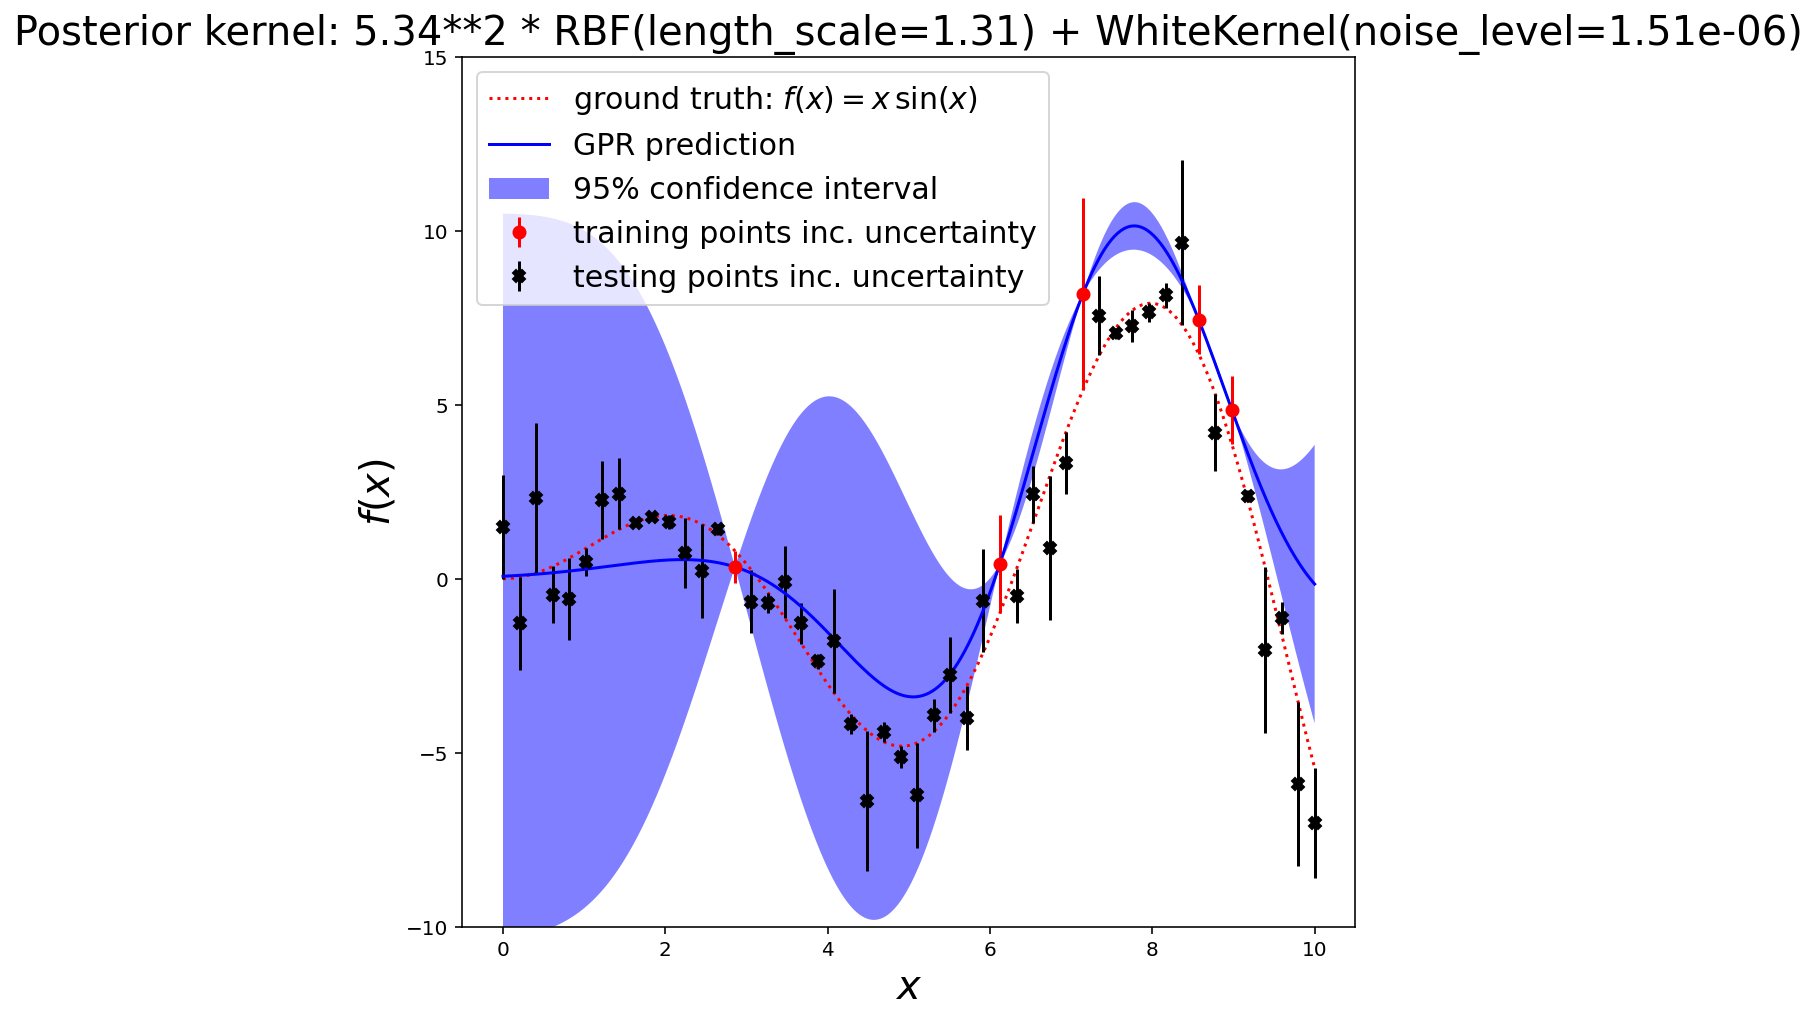

In [12]:
fig1 # plot figure.

Note: the above figure may not have learned the noise properly (if you use few training points). Go back to the beginning of the notebook and change the test_ratio to 0.7 (instead of 0.9) and run the entire notebook again. You will see that it learns the noise (approximately)! Pretty cool!

### You will explore these and other things in Homework 5

Have fun!

### Solution for Exercise 1

```python
# We start by importing the polynomial predictor from scikit-learn
from sklearn.preprocessing import PolynomialFeatures # For Polynomial fit
from sklearn.linear_model import LinearRegression # For Least Squares
from sklearn.pipeline import make_pipeline # to link different objects

degree = 4 # degree of polynomial we want to fit
poly_model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model.fit(X_train,y_train) # fit the polynomial to our 5 points in X_train which is a 2D array  
y_poly_pred = poly_model.predict(X_test) # prediction of our polynomial

from sklearn.metrics import mean_squared_error, r2_score # Import error metrics
# Compute MSE and R2 for the GP model
gp_mse_value = mean_squared_error(y_test, y_pred)
gp_r2_value = r2_score(y_test, y_pred)
print('MSE for GPR = ', gp_mse_value)
print('R2 score for GPR = ', gp_r2_value)

# Compute MSE and R2 for the polynomial model
poly_mse_value = mean_squared_error(y_test, y_poly_pred)
poly_r2_value = r2_score(y_test, y_poly_pred)
print('MSE for polynomial = ', poly_mse_value)
print('R2 score for polynomial = ', poly_r2_value)
```

### Solution to Exercise 2

``` python
degree = 4 # degree of polynomial we want to fit
poly_model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model.fit(X_train,y_noisy_train) # fit the polynomial to our 5 points in X_train which is a 2D array
y_poly_noisy_pred = poly_model.predict(X_test) # prediction of our polynomial

# Compute MSE and R2 for the GP model
# NOTE: here we will compare with the noiseless function (in practice we don't have this information!).
gp_mse_value = mean_squared_error(y_test, y_noisy_pred)
gp_r2_value = r2_score(y_test, y_noisy_pred)
print('MSE for GPR = ', gp_mse_value)
print('R2 score for GPR = ', gp_r2_value)

# Compute MSE and R2 for the polynomial model
poly_mse_value = mean_squared_error(y_test, y_poly_noisy_pred)
poly_r2_value = r2_score(y_test, y_poly_noisy_pred)
print('MSE for polynomial = ', poly_mse_value)
print('R2 score for polynomial = ', poly_r2_value)
```